In [239]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.core.display import HTML
from textblob import TextBlob as tb
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import textstat as ts
import seaborn as sns
from math import log10
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy as s
import os, sys
import plotly 

In [108]:
key = os.environ['PLOTLY_API_KEY']
plotly.tools.set_credentials_file(username='colejhudson', api_key=key)

In [109]:
init_notebook_mode(connected=True)

In [5]:
book_reviews = pd.read_csv('../data/amazon/amazon_reviews_50k_sample.tsv', sep='\t', encoding='utf8', error_bad_lines=False)

b'Skipping line 14567: expected 15 fields, saw 22\n'


## What does our sample look like?

In [6]:
book_reviews.describe()[['star_rating', 'helpful_votes', 'total_votes']].T

,count,mean,std,min,25%,50%,75%,max
star_rating,49914.0,4.444945,1.038297,1.0,4.0,5.0,5.0,5.0
helpful_votes,49914.0,1.504508,10.445947,0.0,0.0,0.0,1.0,829.0
total_votes,49914.0,2.196979,12.655699,0.0,0.0,0.0,2.0,897.0


## What period does our sample span?

In [7]:
book_reviews.review_date = pd.to_datetime(book_reviews.review_date)

In [8]:
book_reviews.review_date.dt.month.unique()

array([  3.,  10.,  12.,   1.,   9.,   8.,  11.,   2.,   4.,   7.,   6.,
         5.,  nan])

In [9]:
book_reviews.review_date.dt.year.unique()

array([ 2014.,  2013.,  2015.,  2012.,    nan])

In [9]:
book_reviews.review_date.dt.to_period("M").unique()

array([Period('2014-03', 'M'), Period('2014-10', 'M'),
       Period('2013-12', 'M'), Period('2015-01', 'M'),
       Period('2014-09', 'M'), Period('2015-08', 'M'),
       Period('2013-11', 'M'), Period('2015-03', 'M'),
       Period('2014-01', 'M'), Period('2013-09', 'M'),
       Period('2012-10', 'M'), Period('2013-10', 'M'),
       Period('2015-02', 'M'), Period('2013-01', 'M'),
       Period('2015-04', 'M'), Period('2014-07', 'M'),
       Period('2013-08', 'M'), Period('2012-12', 'M'),
       Period('2015-06', 'M'), Period('2014-11', 'M'),
       Period('2013-02', 'M'), Period('2014-05', 'M'),
       Period('2012-05', 'M'), Period('2015-05', 'M'),
       Period('2013-06', 'M'), Period('2014-04', 'M'),
       Period('2012-09', 'M'), Period('2013-05', 'M'),
       Period('2014-08', 'M'), Period('2013-03', 'M'),
       Period('2012-08', 'M'), Period('2014-12', 'M'),
       Period('2013-07', 'M'), Period('2015-07', 'M'),
       Period('2012-11', 'M'), Period('2012-06', 'M'),
       Per

## How many unique products are included in the sample?

In [219]:
book_reviews['product_id'].isna().sum()

0

In [223]:
sample_size = book_reviews.shape[0]
unique_products = book_reviews['product_id'].unique().size

In [224]:
print("There are {} unique books in the sample".format(unique_products))

There are 44397 unique books in the sample


In [237]:
print("In this sample, {:.0%} of the books included are unique, or have only one review.".format(unique_products/sample_size))

In this sample, 89% of the books included are unique, or have only one review.


## How many unique customers are included in the sample?

In [227]:
unique_customers = book_reviews['customer_id'].unique().size

In [229]:
print("There are {} unique books in the sample".format(unique_customers))

There are 47994 unique books in the sample


In [236]:
print("In this sample, {:.0%} of the customers are unique, or have nor written more than one review.".format(unique_customers/sample_size))

In this sample, 96% of the customers are unique, or have nor written more than one review.


## Do reviewers hold a consistent dispoition across all their reviews?

In [ ]:
book_reviews['star_rating'] = pd.to_numeric(book_reviews['star_rating'], errors='drop')

In [11]:
ratings_per_customer = book_reviews[['customer_id', 'star_rating']].groupby('customer_id')
rating_variance_per_customer = ratings_per_customer.var()

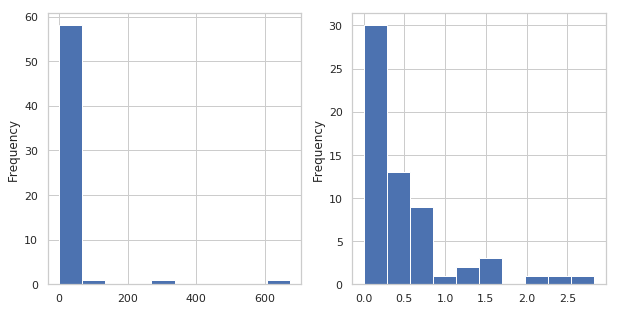

In [287]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

rating_variance_per_customer.dropna()['star_rating'].value_counts().plot.hist(ax=ax[0])
rating_variance_per_customer.dropna()['star_rating'].value_counts().apply(log10).plot.hist(ax=ax[1])

## What the distribution of total votes left, across all reviews?

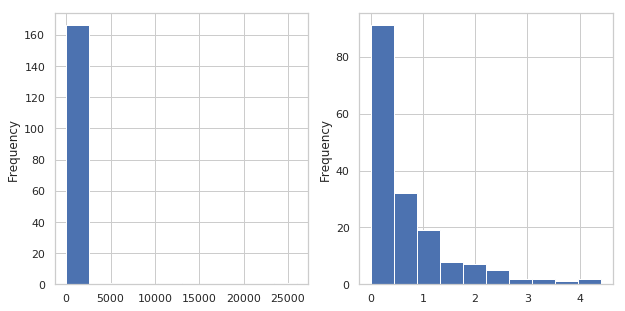

In [289]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

book_reviews['total_votes'].value_counts().plot.hist(ax=ax[0])
book_reviews['total_votes'].value_counts().apply(log10).plot.hist(ax=ax[1])

## What's the distribution of helpful votes among all reviews left?

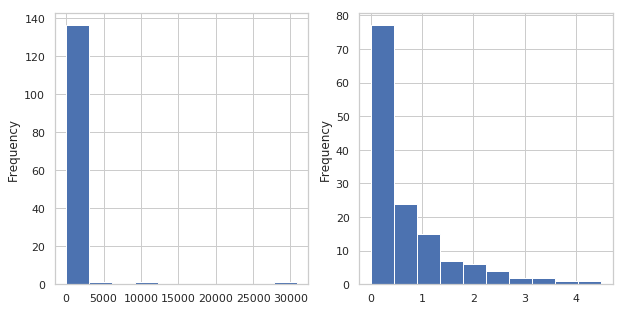

In [286]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

book_reviews['helpful_votes'].value_counts().plot.hist(ax=ax[0])
book_reviews['helpful_votes'].value_counts().apply(log10).plot.hist(ax=ax[1])

## Of those reviews considered helpful at all, what distribution do they form?

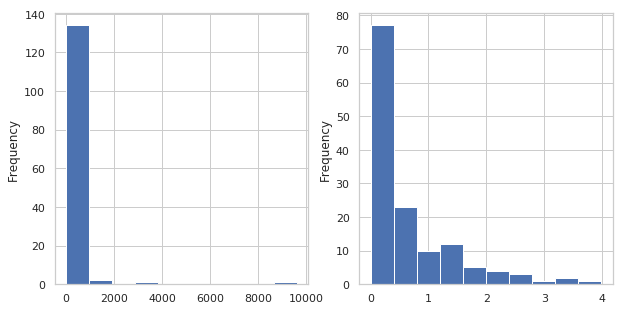

In [285]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

book_reviews['helpful_votes'][book_reviews['helpful_votes'] > 0].value_counts().plot.hist(ax=ax[0])
book_reviews['helpful_votes'][book_reviews['helpful_votes'] > 0].value_counts().apply(log10).plot.hist(ax=ax[1])

## Of those who leave more nuanced ratings, how helpful are there reviews considered?

In [115]:
nuance_threshhold = 2

nuanced_users = book_reviews[['customer_id', 'star_rating']].groupby('customer_id').var().dropna() > nuance_threshhold

book_reviews['is_nuanced'] = book_reviews['customer_id'].isin(nuanced_users.index.values)
book_reviews['is_not_nuanced'] = ~book_reviews.is_nuanced

In [132]:
helpful_threshold = 1

book_reviews['is_helpful'] = book_reviews['helpful_votes'] > helpful_threshold
book_reviews['is_not_helpful'] = ~book_reviews.is_helpful

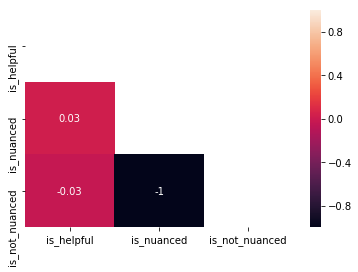

In [139]:
nuance_by_rating_correlation = book_reviews[['is_helpful', 'is_nuanced', 'is_not_nuanced']].corr()

mask = np.zeros_like(nuance_by_rating_correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(nuance_by_rating_correlation, annot=True, mask=mask)

## What percentage of reviewers actually bought the book?

In [14]:
# In the entire subset extracted from the Amazon data it seems that only 9 non-reviews were included, 
# hence to answer this we just need to cast the verified_purchase column into True vs False, and then
# create a cat plot

book_reviews.review_body.isnull().sum()

0

Text(0.5,1,'What percentage of reviewers actually bought the book?')

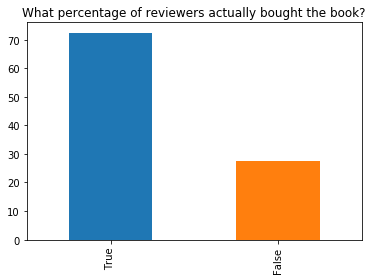

In [15]:
# Notably, this answers the question about the 80/20 rule

percent_purchased = ((book_reviews.verified_purchase.value_counts()/book_reviews.verified_purchase.size) * 100)

percent_purchased.rename(index={'Y': True, 'N': False}).plot.bar()

plt.title("What percentage of reviewers actually bought the book?")

## What percentage of people who left one star ratings bought the book?

In [17]:
book_reviews['rated_five'] = book_reviews['star_rating'] == 5
book_reviews['rated_four'] = book_reviews['star_rating'] == 4
book_reviews['rated_three'] = book_reviews['star_rating'] == 3
book_reviews['rated_two'] = book_reviews['star_rating'] == 2
book_reviews['rated_one'] = book_reviews['star_rating'] == 1

book_reviews['did_purchase'] = book_reviews['verified_purchase'] == 'Y'
book_reviews['did_not_purchase'] = book_reviews['verified_purchase'] == 'N'

In [262]:
one_stars = book_reviews.star_rating[book_reviews.rated_one].size
one_stars_who_purchased = book_reviews.star_rating[(book_reviews.verified_purchase == 'Y') & (book_reviews.star_rating == 1)].size

print("Of those who left a one star rating, only {:.0%} are verified as having purchased the book as well".format(one_stars_who_purchased/one_stars))

Of those who left a one star rating, only 58% are verified as having purchased the book as well


## Of each star rating, what percentage of users in that cohort actually purchased the book?

In [291]:
def percentage_that_purchased(value):
    cohort = (book_reviews.star_rating == value).size
    cohort_who_purchased = book_reviews.star_rating[(book_reviews.verified_purchase == 'Y') & (book_reviews.star_rating == value)].size
    return cohort_who_purchased/cohort

possible_ratings = book_reviews.star_rating.unique()
percentage_purchased_by_rating = pd.DataFrame()

for rating in possible_ratings:
    print("Of those who rated a product {} stars, only {:.0%} were verified as having bought the book".format(rating, percentage_that_purchased(rating)))
    percentage_purchased_by_rating[rating] = pd.Series([percentage_that_purchased(rating)])

Of those who rated a product 5 stars, only 53% were verified as having bought the book
Of those who rated a product 4 stars, only 11% were verified as having bought the book
Of those who rated a product 2 stars, only 2% were verified as having bought the book
Of those who rated a product 1 stars, only 2% were verified as having bought the book
Of those who rated a product 3 stars, only 5% were verified as having bought the book


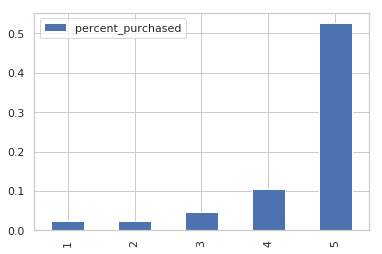

In [194]:
percentage_purchased_by_rating.T.rename(columns={0: 'percent_purchased'}).sort_index().plot.bar()

## What's the correlation between buying the book and giving it a favorable (greater than average) review?

In [243]:
average_star_rating = book_reviews['star_rating'].mean()

book_reviews['is_favorable'] = book_reviews['star_rating'] > average_star_rating

In [244]:
favorability_correlated_to_purchase = book_reviews[['is_favorable', 'verified_purchase']].replace({'Y': 1, 'N': 0}).corr()

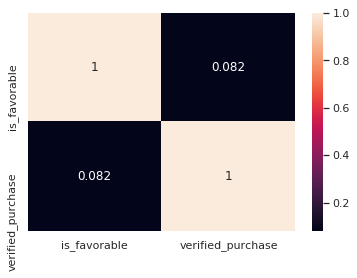

In [245]:
sns.heatmap(favorability_correlated_to_purchase, annot=True)

## How frequently was each rating given?

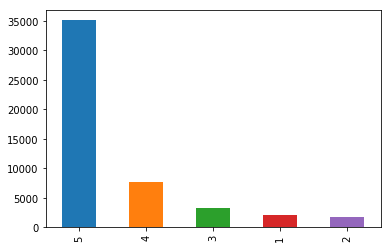

In [24]:
book_reviews['star_rating'].fillna(0).value_counts().plot.bar()

In [25]:
book_reviews['star_rating'].isna().sum()

0

## What's the correlation between each rating and having purchased the book rated?

Text(0.5,1,'Correlation A User Leaving Each Rating And Having Purchased The Book')

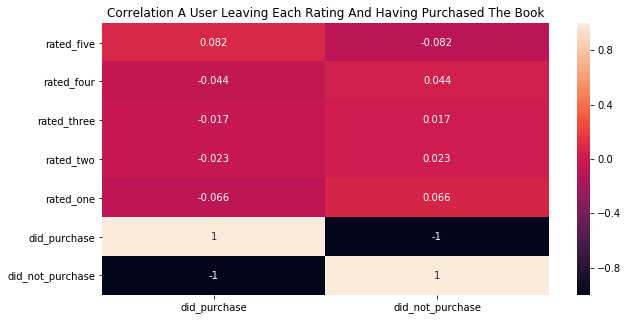

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

purchases_by_ratings_left = book_reviews[[
    'rated_five', 
    'rated_four', 
    'rated_three', 
    'rated_two', 
    'rated_one',
    'did_purchase',
    'did_not_purchase'
]]

sns.heatmap(
    purchases_by_ratings_left.corr()[['did_purchase', 'did_not_purchase']],
    annot=True,
    ax=ax
)

plt.title("Correlation A User Leaving Each Rating And Having Purchased The Book")

## How many reviews have been left each quarter?

In [534]:
book_reviews['quarters'] = book_reviews.review_date.dt.to_period('Q')

In [543]:
quarterly_review_count = book_reviews[['quarters', 'review_id']].groupby('quarters').count().reset_index().sort_values(by='quarters')

Text(0.5,1,'Number Of Ratings Made Each Quarter')

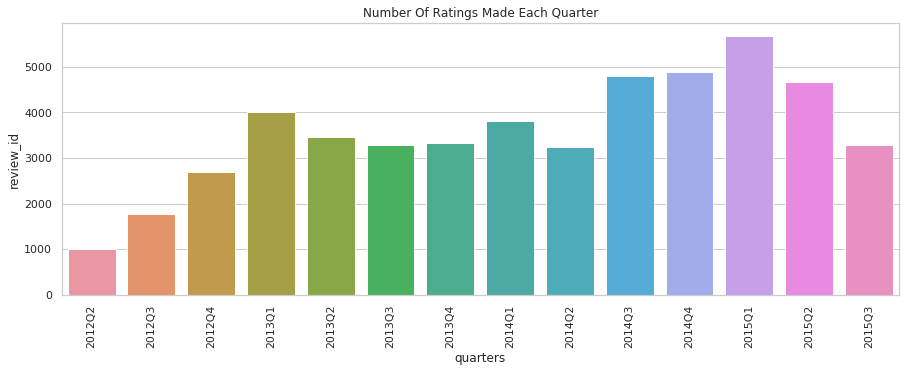

In [545]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(
    y='review_id',
    x='quarters',
    data=quarterly_review_count,
    ax=ax
)

plt.xticks(rotation=90);
plt.title("Number Of Ratings Made Each Quarter")

## How have reviews changed over Amazon's lifetime?

In [24]:
book_reviews['review_body_length'] = book_reviews.review_body.str.len()
book_reviews['review_token_count'] = book_reviews.review_body.str.split(' ').apply(len)
book_reviews['review_syllable_count'] = book_reviews.review_body.apply(ts.syllable_count)
book_reviews['review_sentence_count'] = book_reviews.review_body.apply(ts.sentence_count)

In [15]:
book_reviews['month_by_year'] = book_reviews.review_date.dt.to_period("M")

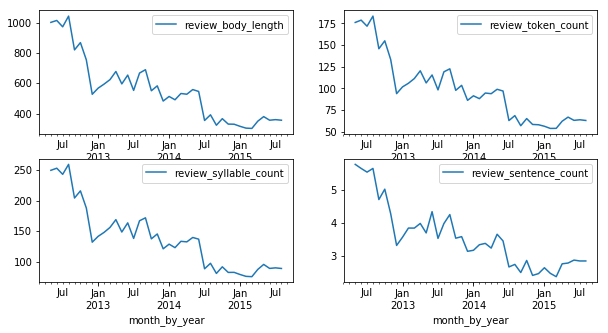

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

book_reviews[['review_body_length', 'month_by_year']].groupby('month_by_year').mean().plot.line(ax=ax[0][0])
book_reviews[['review_token_count', 'month_by_year']].groupby('month_by_year').mean().plot.line(ax=ax[0][1])
book_reviews[['review_syllable_count', 'month_by_year']].groupby('month_by_year').mean().plot.line(ax=ax[1][0])
book_reviews[['review_sentence_count', 'month_by_year']].groupby('month_by_year').mean().plot.line(ax=ax[1][1])

## How many reviews have been written each month, split out by year? 

In [17]:
book_reviews['month'] = book_reviews.review_date.dt.month
book_reviews['year'] = book_reviews.review_date.dt.year

In [18]:
review_frequency_each_month_per_year = book_reviews[['review_id', 'month', 'year']]\
                                        .groupby(['year', 'month'])\
                                        .count()\
                                        .reset_index()\
                                        .rename(columns={'review_id': 'frequency'})

log_review_frequency_each_month_per_year = review_frequency_each_month_per_year.assign(frequency=review_frequency_each_month_per_year.frequency.apply(log10))

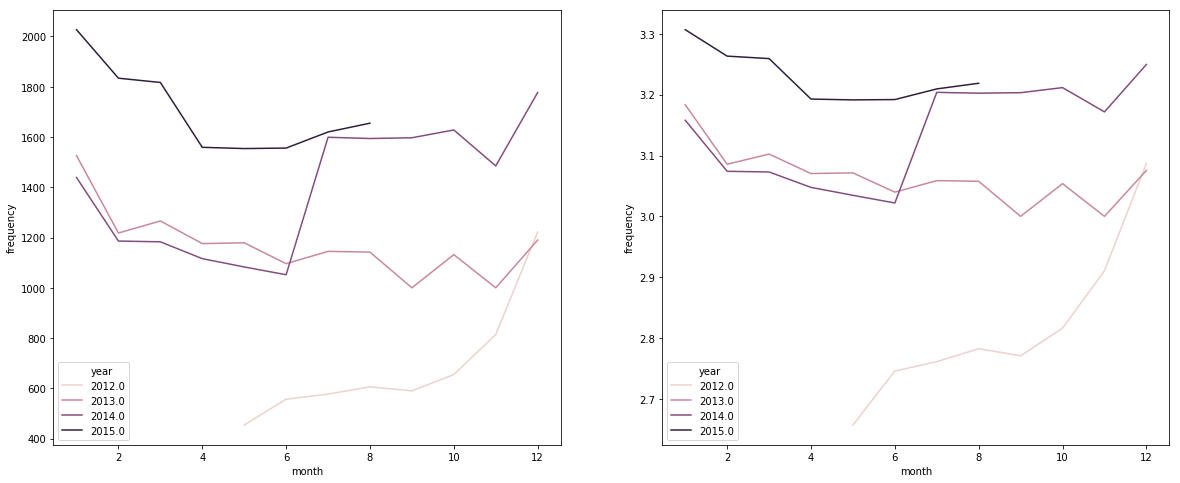

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(
    x='month',
    y='frequency',
    hue='year',
    data=review_frequency_each_month_per_year,
    ax=ax[0]
)

sns.lineplot(
    x='month',
    y='frequency',
    hue='year',
    data=log_review_frequency_each_month_per_year,
    ax=ax[1]
)

## How has the number of reviews written changed over time, across all possible star ratings?

In [43]:
reviews_over_time = ratings_by_review_length_and_period.count().reset_index()
log_reviews_over_time = reviews_over_time.assign(log_review_body_length=reviews_over_time.review_body_length.apply(log10))

In [49]:
plot_friendly_reviews_over_time = reviews_over_time.assign(
    star_rating=reviews_over_time.star_rating.apply(str)
)

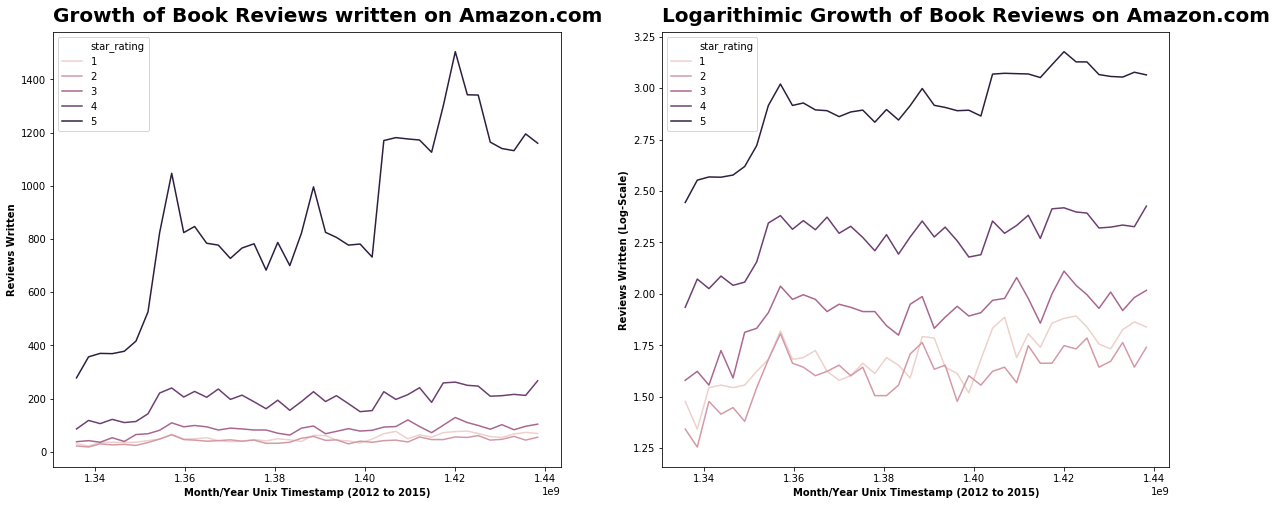

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(
    x='unix_month_by_year',
    y='review_body_length',
    hue='star_rating',
    data=reviews_over_time,
    legend='full',
    ax=ax[0]
)

sns.lineplot(
    x='unix_month_by_year',
    y='log_review_body_length',
    hue='star_rating',
    data=log_reviews_over_time,
    legend='full',
    ax=ax[1]
)

ax[0].set_title("Growth of Book Reviews written on Amazon.com", fontsize=20, weight='bold', loc='left', pad=10)
ax[1].set_title("Logarithimic Growth of Book Reviews on Amazon.com", fontsize=20, weight='bold', loc='left', pad=10)
ax[0].set_xlabel('Month/Year Unix Timestamp (2012 to 2015)', fontsize=10, weight='bold')
ax[1].set_xlabel('Month/Year Unix Timestamp (2012 to 2015)', fontsize=10, weight='bold')
ax[0].set_ylabel('Reviews Written', fontsize=10, weight='bold')
ax[1].set_ylabel('Reviews Written (Log-Scale)', fontsize=10, weight='bold')

plt.savefig('review-length-over-time-lineplots.png')

## How has the average length of a book review changed over time, split out over each rating?

In [211]:
review_length_over_time = ratings_by_review_length_and_period.mean().reset_index()
log_review_length_over_time = review_length_over_time.assign(log_review_body_length=review_length_over_time.review_body_length.apply(log10))

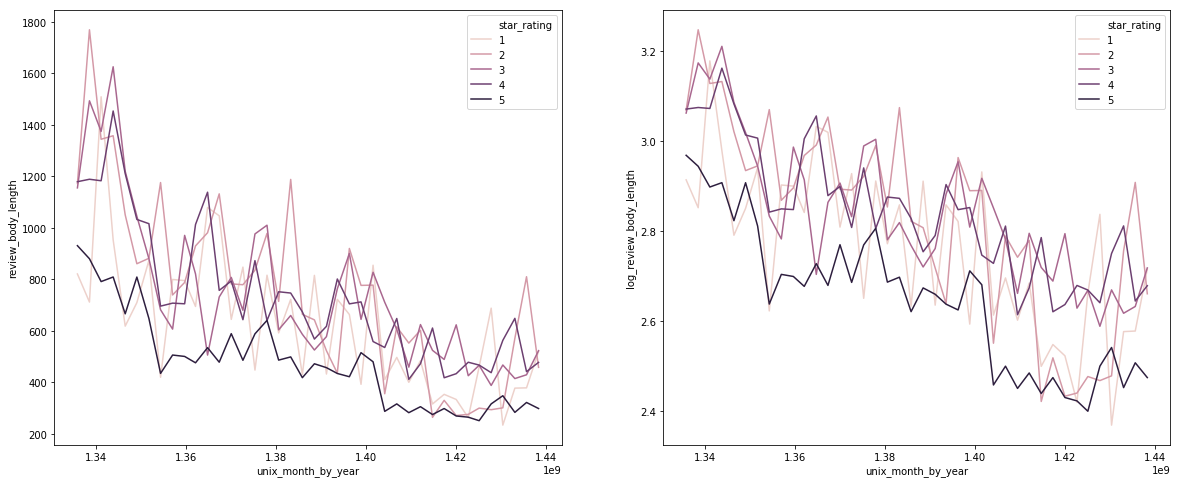

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(
    x='unix_month_by_year',
    y='review_body_length',
    hue='star_rating',
    data=review_length_over_time,
    legend='full',
    ax=ax[0]
)

sns.lineplot(
    x='unix_month_by_year',
    y='log_review_body_length',
    hue='star_rating',
    data=log_review_length_over_time,
    legend='full',
    ax=ax[1]
)


## How has the reading level of reviews shifted over time?

In [80]:
book_reviews['review_grade_level'] = book_reviews.review_body.apply(ts.automated_readability_index)

In [51]:
review_grade_level_per_timeperiod = book_reviews[['review_grade_level', 'unix_month_by_year']]

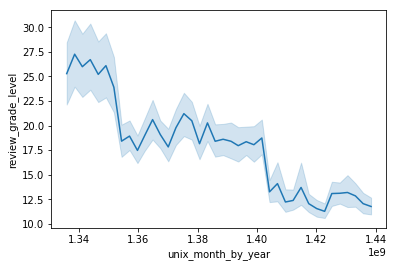

In [52]:
sns.lineplot(
    x='unix_month_by_year',
    y='review_grade_level',
    data=review_grade_level_per_timeperiod
)

## How has the reading ease of reviews changed over time?

In [ ]:
book_reviews['review_reading_ease_score'] = book_reviews.review_body.apply(ts.flesch_reading_ease)

In [181]:
reading_ease_per_timeperiod = book_reviews[['review_reading_ease_score', 'unix_month_by_year']]

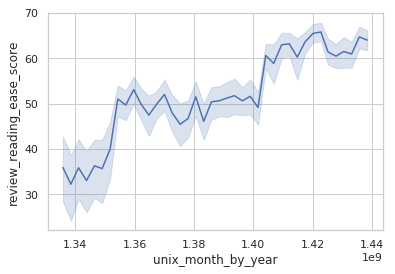

In [182]:
sns.lineplot(
    x='unix_month_by_year',
    y='review_reading_ease_score',
    data=reading_ease_per_timeperiod
)

## What relationship exists between the reading ease and level of reviews?

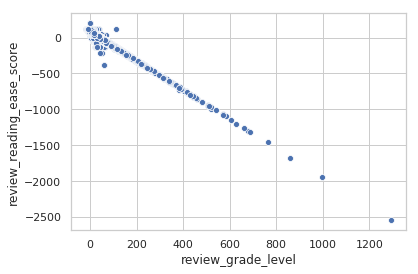

In [451]:
sns.scatterplot(
    x=book_reviews['review_grade_level'],
    y=book_reviews['review_reading_ease_score']
)

## How has the relationship between reading ease and reading level changed over time?

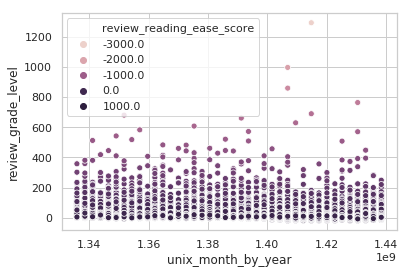

In [453]:
sns.scatterplot(
    y=book_reviews['review_grade_level'],
    x=book_reviews['unix_month_by_year'],
    hue=book_reviews['review_reading_ease_score']
)

## What is the distribution of readability among reviews left on purchase products?

In [140]:
difficulties = ['very_easy', 'easy', 'fairly_easy', 'standard', 'fairly_difficult', 'difficult', 'very_confusing']
upper_bounds = [0, 30, 60, 70, 80, 90, 122, float('inf')]

book_reviews['readability'] = pd.cut(book_reviews.review_reading_ease_score, upper_bounds, include_lowest=True, labels=difficulties)
book_reviews['factorized_readability'] = pd.factorize(book_reviews.readability)[0]

In [168]:
book_reviews[['readability', 'verified_purchase']].groupby('verified_purchase').count()

,readability
verified_purchase,
N,11807
Y,34040


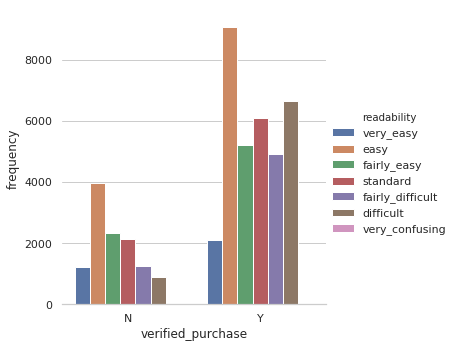

In [180]:
sns.set(style="whitegrid")

g = sns.catplot(
    kind='bar',
    y='frequency',
    x='verified_purchase',
    hue='readability',
    data=book_reviews[['readability', 'verified_purchase']].groupby(['verified_purchase', 'readability']).size().reset_index().rename(columns={0: 'frequency'})
)

g.despine(left=True)

## What's the most common rating behavior amongst users? 

In [51]:
# If we take the average of ratings left by each user across all ratings said customer
# has left, we'll effectively bin the data between 1 and 5 and get a hint at the dynamics
# underlying the rating of books

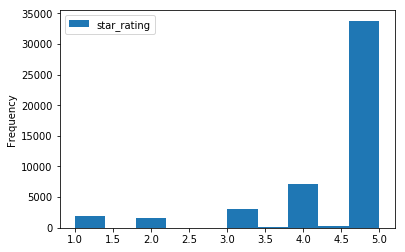

In [49]:
book_reviews[['customer_id', 'star_rating']].groupby('customer_id').mean().plot.hist()

## What's the correlation between total votes given to a review, and how helpful its deemed?

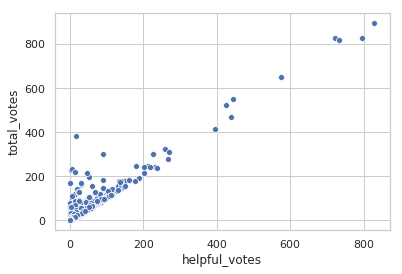

In [426]:
sns.scatterplot(
    x='helpful_votes',
    y='total_votes',
    data=book_reviews[['helpful_votes', 'total_votes']]
)

## Which months see the most ratings left?

In [377]:
ratings_count_per_month = book_reviews[['star_rating', 'month']].groupby(['month', 'star_rating']).size()

In [409]:
ratings_per_month_matrix = ratings_per_month.reset_index().rename(columns={0: 'frequency'}).pivot(
    index='month',
    columns='star_rating',
    values='frequency'
)

normalized_ratings_per_month_matrix = (ratings_per_month_matrix-ratings_per_month_matrix.mean())/ratings_per_month_matrix.std()
log_rating_per_month = ratings_per_month_matrix.apply(lambda s: s.apply(log10), axis=0)

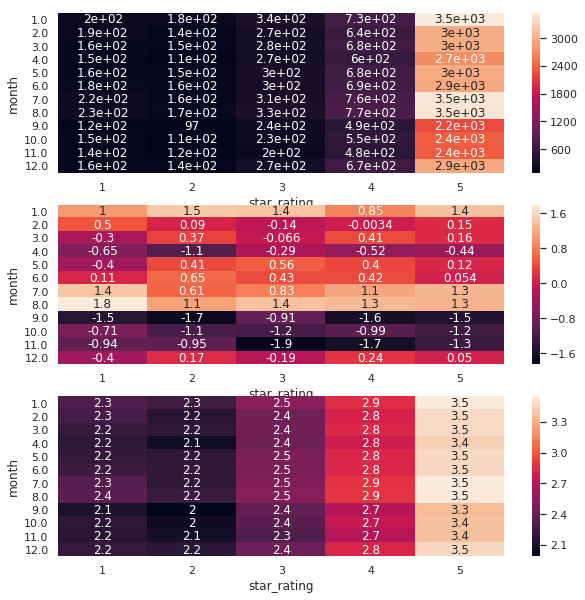

In [413]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.heatmap(ratings_per_month_matrix, ax=ax[0], annot=True)
sns.heatmap(normalized_ratings_per_month_matrix, ax=ax[1], annot=True)
sns.heatmap(log_rating_per_month, ax=ax[2], annot=True)

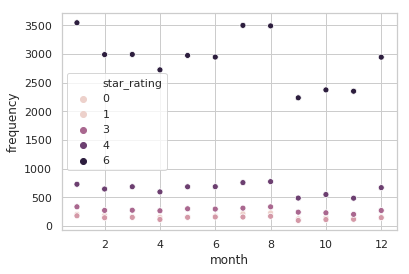

In [438]:
sns.scatterplot(
    x='month',
    y='frequency',
    hue='star_rating',
    data=ratings_count_per_month.reset_index().rename(columns={0: 'frequency'})
)

In [380]:
ratings_per_month = ratings_count_per_month.reset_index().rename(columns={0: 'frequency'})
log_ratings_per_month = ratings_per_month.assign(frequency=ratings_per_month.frequency.apply(log10))

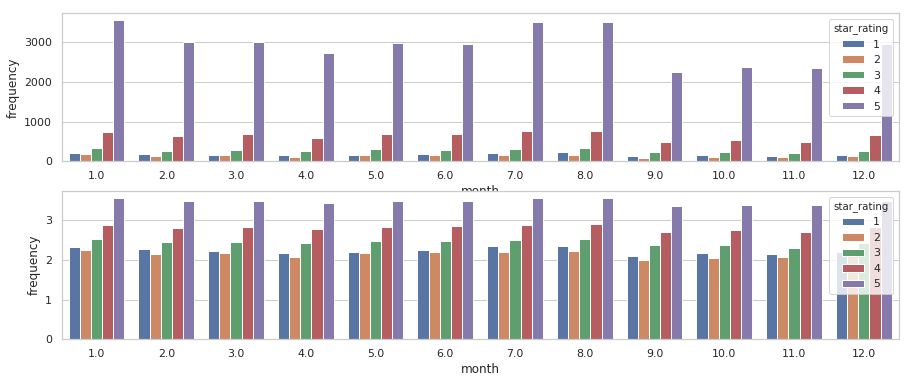

In [417]:
fig, ax = plt.subplots(2, 1, figsize=(15, 6))

sns.barplot(
    x='month',
    y='frequency',
    hue='star_rating',
    data=ratings_per_month,
    ax=ax[0]
)

sns.barplot(
    x='month',
    y='frequency',
    hue='star_rating',
    data=log_ratings_per_month,
    ax=ax[1]
)

## How does the reading level of a review correlate with its engagement?

In [101]:
book_reviews.review_grade_level.describe()

count    49914.000000
mean        16.530328
std         29.835966
min        -16.300000
25%          5.700000
50%         10.000000
75%         16.700000
max       1291.400000
Name: review_grade_level, dtype: float64

23603    897
33502    828
14118    826
41031    820
24149    653
Name: total_votes, dtype: int64

In [198]:
most_voted_for = tuple(book_reviews[['review_grade_level', 'total_votes']].sort_values(by='total_votes', ascending=False)[:1].values[0])
most_voted_for

(72.099999999999994, 897.0)

In [199]:
most_complex_writing = tuple(book_reviews[['review_grade_level', 'total_votes']].sort_values(by='review_grade_level', ascending=False)[:1].values[0])
most_complex_writing

(1291.4000000000001, 13.0)

In [171]:
most_complicated = book_reviews.review_grade_level.sort_values(ascending=False)[:1]
most_complicated

30117    1291.4
Name: review_grade_level, dtype: float64

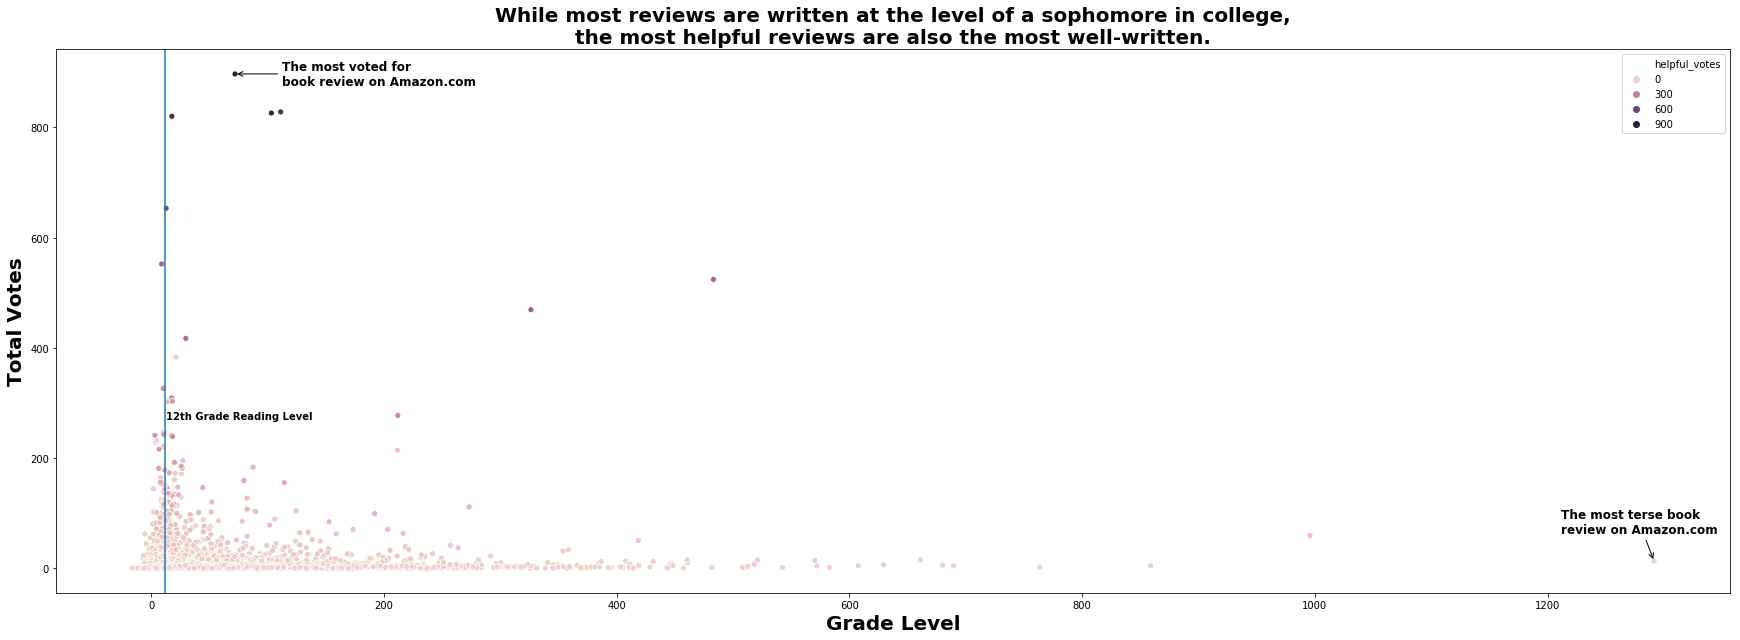

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))



sns.scatterplot(
    x=book_reviews.review_grade_level,
    y=book_reviews.total_votes,
    hue=book_reviews.helpful_votes,
    ax=ax
)

plt.axvline(12)
plt.text(13, 270, s="12th Grade Reading Level", weight='bold')

plt.annotate(
    xy=most_complex_writing, 
    xytext=(most_complex_writing[0]-80, most_complex_writing[1]+50),
    arrowprops={ 'arrowstyle': '->' },
    s="The most terse book \nreview on Amazon.com",
    weight='bold',
    fontsize=12
)

plt.annotate(
    xy=most_voted_for, 
    xytext=(most_voted_for[0]+40, most_voted_for[1]-20),
    arrowprops={ 'arrowstyle': '->' },
    s="The most voted for \nbook review on Amazon.com", 
    weight='bold',
    fontsize=12
)

plt.title("While most reviews are written at the level of a sophomore in college,\nthe most helpful reviews are also the most well-written.", fontsize=20, weight='bold')
plt.xlabel('Grade Level', weight='bold', fontsize=20)
plt.ylabel('Total Votes', weight='bold', fontsize=20)
plt.savefig('reading-level-by-total-votes-scatterplot.png')

In [257]:
marker = go.scatter3d.Marker(
    colorscale='Hot',
    size=3,
    opacity=0.2,
    line=go.scatter3d.marker.Line(color='black',width=2)
)

trace1 = go.Scatter3d(
    x=book_reviews.review_grade_level[:10000],
    y=book_reviews.total_votes[:10000],
    z=book_reviews.helpful_votes[:10000],
    mode='markers',
    marker=marker
)

layout = go.Layout(
    scene = dict(
        xaxis=dict(title='Grade Level'), 
        yaxis = dict(title='Total Votes'), 
        zaxis = dict(title='Helpful Votes')
    )
)

fig = go.Figure(data=[trace1], layout=layout)

py.iplot(fig, filename='reading-level-helpfulness-total-votes-scatter')

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## What does the readability of the review tell us about how helpful it was?

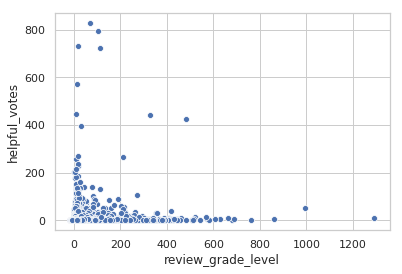

In [442]:
sns.scatterplot(
    x=book_reviews.review_grade_level,
    y=book_reviews.helpful_votes
)

## What percent of vine reviewers purchased the product in question?

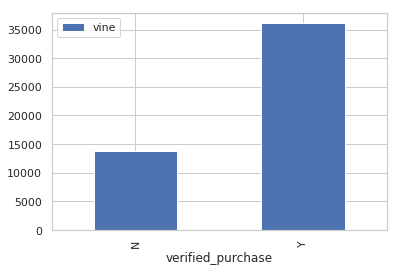

In [448]:
book_reviews[['vine', 'verified_purchase']].groupby('verified_purchase').count().plot.bar()

## What percentage of all reviewers were vine reviewers?

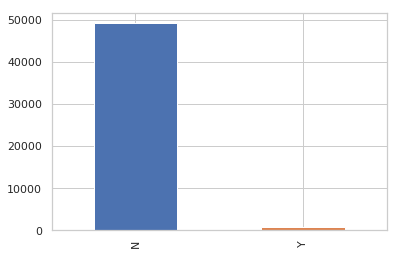

In [449]:
book_reviews['vine'].value_counts().plot.bar()

## How does being apart of the vine program correlated with helpfulness?

In [458]:
book_reviews[['vine', 'helpful_votes']].groupby('vine').mean()

,helpful_votes
vine,
N,1.466229
Y,4.138462


## Is the helpfulness of reviews in the vine program significant?

In [241]:
vine_helpfulness = book_reviews[book_reviews['vine'] == 'Y']['helpful_votes']
nonvine_helpfulness = book_reviews[book_reviews['vine'] == 'N']['helpful_votes']

In [243]:
# Null: Vine reviewers are no more helpful than non-vine reviewers
stat, pvalue = s.stats.ttest_ind(vine_helpfulness, nonvine_helpfulness)

if pvalue < 0.05:
    print("The null is rejected, it's possible that vine reviewers are more helpful than non-vine reviewers")
else: 
    print("The null is confirmed, vine reviewers are no more helpful than non-vine reviewers")

The null is rejected, it's possible that vine reviewers are more helpful than non-vine reviewers


## Whats the relationship between the polarity and subjecitivty of reviews?

In [249]:
analyses = book_reviews.review_body.apply(lambda review: tb(review))

In [250]:
book_reviews['review_polarity'] = analyses.apply(lambda analysis: analysis.sentiment.polarity)
book_reviews['review_subjectivity'] = analyses.apply(lambda analysis: analysis.sentiment.subjectivity)

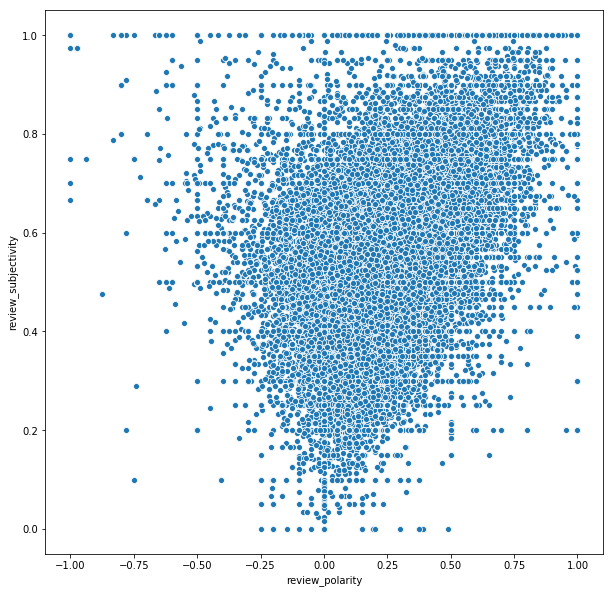

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(
    x=book_reviews['review_polarity'],
    y=book_reviews['review_subjectivity'],
    ax=ax
)

## What's the relationship between star ratings and the sentiment of reviews given?

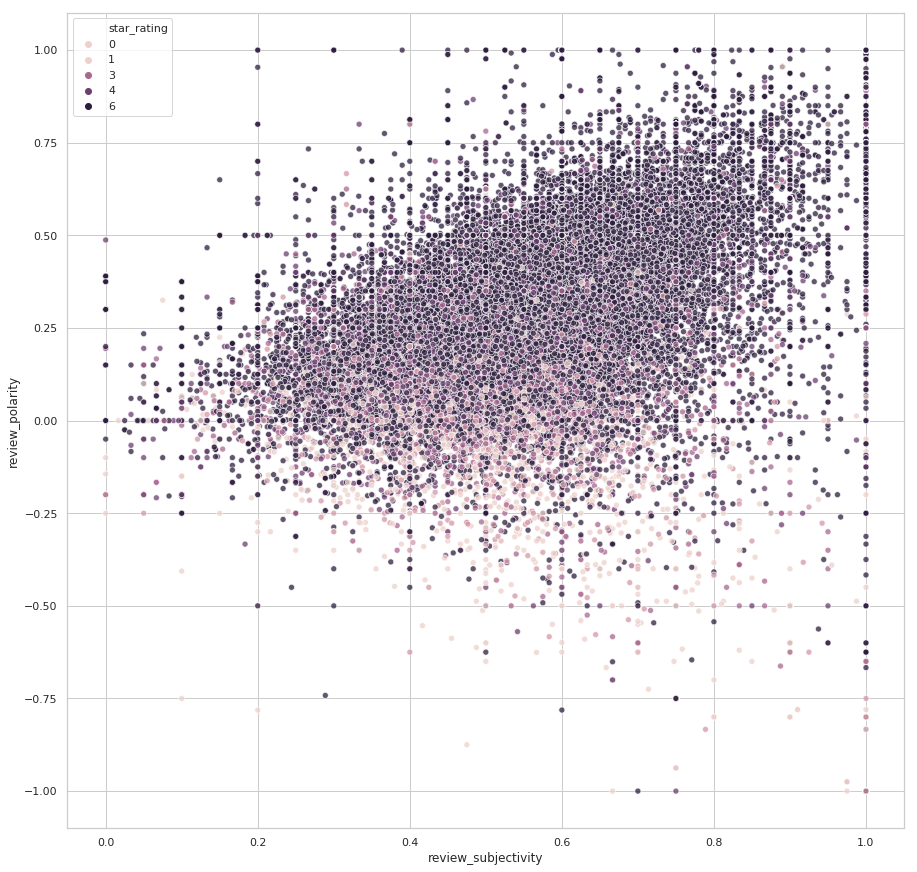

In [568]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

sns.scatterplot(
    x=book_reviews['review_subjectivity'],
    y=book_reviews['review_polarity'],
    hue=book_reviews['star_rating'],
    ax=ax,
    alpha=0.75
)

## What relationsip exists between the sentiment of the review left, the amount of votes, and how helpful it was considered? 

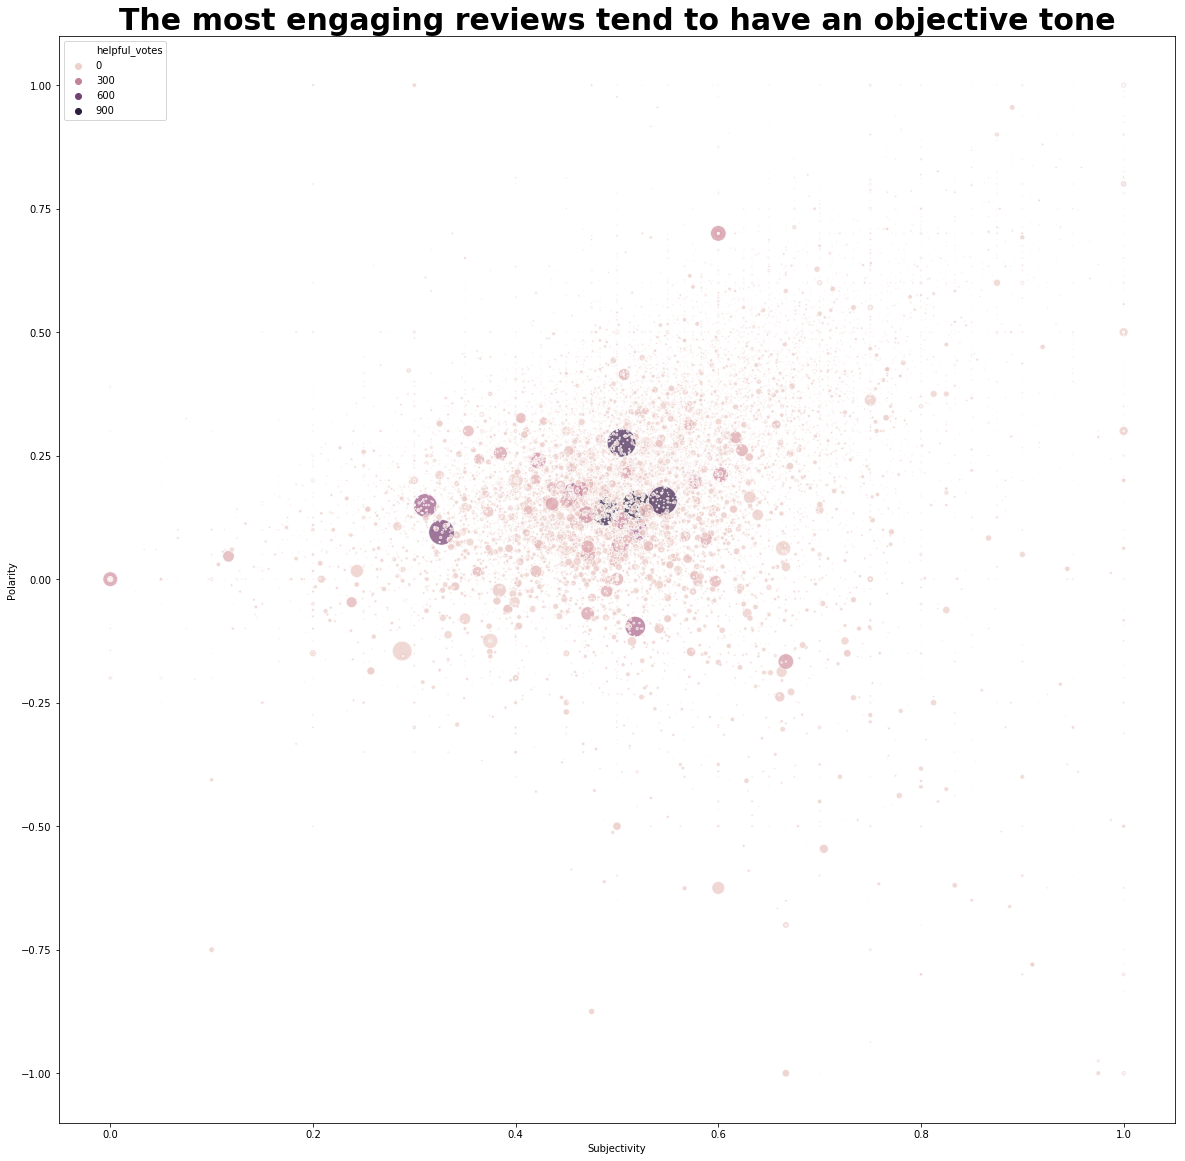

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

sns.scatterplot(
    x=book_reviews['review_subjectivity'],
    y=book_reviews['review_polarity'],
    hue=book_reviews['helpful_votes'],
    s=book_reviews['total_votes'],
    ax=ax,
    alpha=0.75
)

plt.title("The most engaging reviews tend to have an objective tone", fontsize=30, weight='bold')
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.savefig('sentiment-by-votes-scatterplot.png')

In [256]:
marker = go.scatter3d.Marker(
    colorscale='Hot',
    size=3,
    opacity=0.2,
    line=go.scatter3d.marker.Line(color='black',width=0.1)
)

trace1 = go.Scatter3d(
    x=book_reviews['review_subjectivity'][:1000],
    y=book_reviews['review_polarity'][:1000],
    z=book_reviews['total_votes'][:1000],
    mode='markers',
    marker=marker
)

layout = go.Layout(
    scene = dict(
        xaxis=dict(title='Subjectivity'), 
        yaxis = dict(title='Polarity'), 
        zaxis = dict(title='Total Votes')
    )
)

fig = go.Figure(data=[trace1], layout=layout)

py.iplot(fig, filename='polarity-subjectivity-total-votes-scatter')

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## What are the top 25 books with the most votes?

In [521]:
top_25 = book_reviews[['product_title', 'total_votes']].sort_values(by='total_votes', ascending=False)[:25]

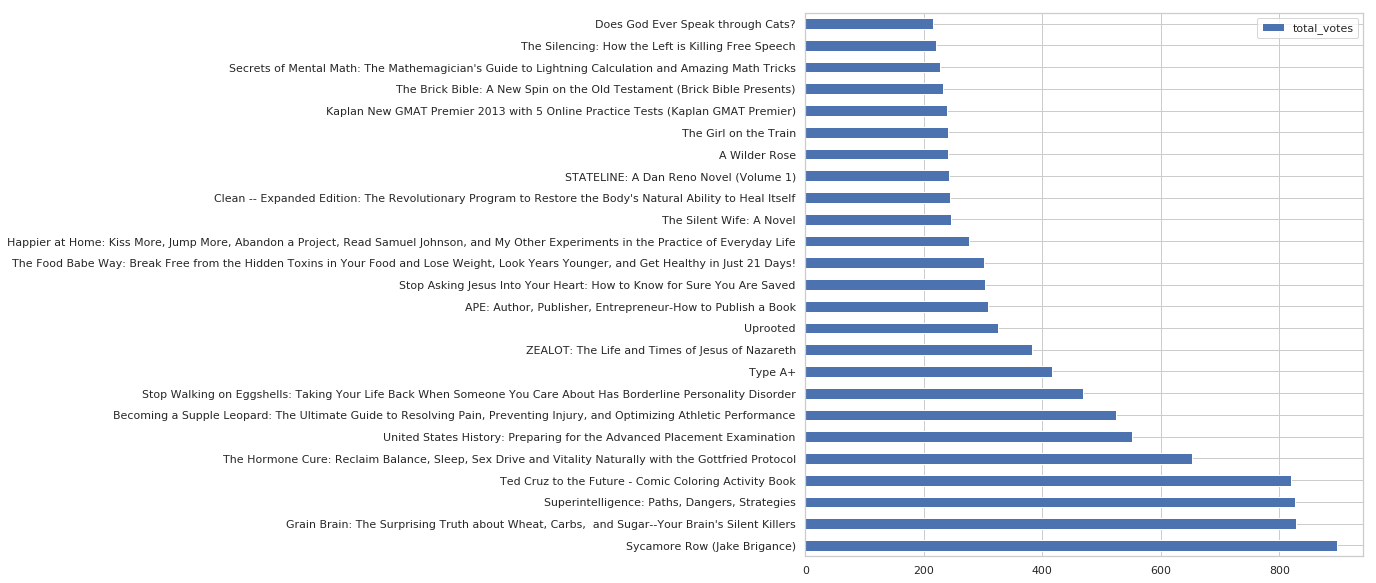

In [524]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


top_25.plot.barh(ax=ax)

ax.set_yticklabels(top_25.product_title);

## What are the top 5 books with the best reviews?

In [586]:
top_5 = top_25[:5]

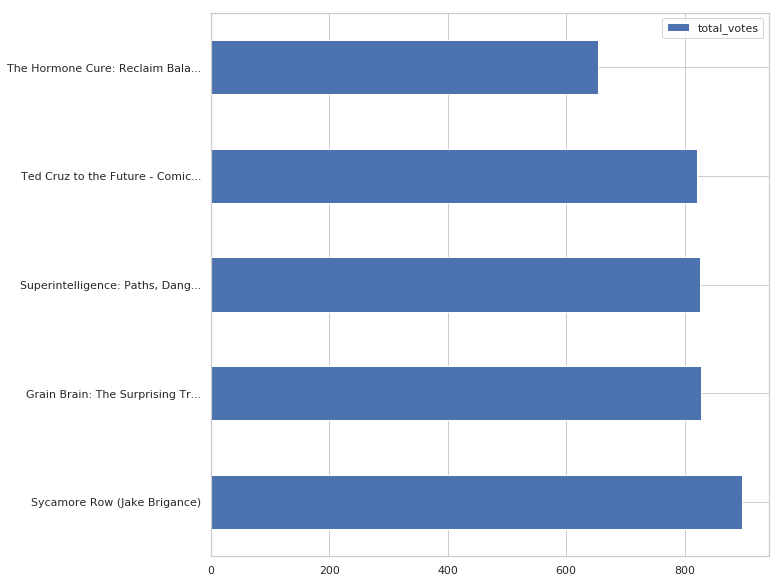

In [589]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


#top_5.plot.barh(ax=ax)
g = sns.catplot(
    
)

labels = [title[:30] + '...' if len(title) > 30 else title for title in top_5.product_title]

ax.set_yticklabels(labels);

## On which books were the most helpful reviews left?

In [525]:
book_reviews[['product_title', 'helpful_votes']].sort_values(by='helpful_votes', ascending=False)[:25]

,product_title,helpful_votes
23603,Sycamore Row (Jake Brigance),829
14118,"Superintelligence: Paths, Dangers, Strategies",796
41031,Ted Cruz to the Future - Comic Coloring Activi...,732
33502,"Grain Brain: The Surprising Truth about Wheat,...",723
24149,"The Hormone Cure: Reclaim Balance, Sleep, Sex ...",574
5711,United States History: Preparing for the Advan...,445
4477,Stop Walking on Eggshells: Taking Your Life Ba...,440
23695,Becoming a Supple Leopard: The Ultimate Guide ...,426
16100,Type A+,394
28729,"APE: Author, Publisher, Entrepreneur-How to Pu...",270


## On which books were the most helpful reviews left normalized by the total number of votes?

In [569]:
normalized_helpful_votes = book_reviews[['product_title', 'helpful_votes', 'total_votes']]
book_reviews['normalized'] = normalized_helpful_votes['helpful_votes']/book_reviews['helpful_votes'].mean()

In [570]:
book_reviews[['product_title', 'normalized']].sort_values(by='normalized', ascending=False)[:25]

,product_title,normalized
23603,Sycamore Row (Jake Brigance),551.010786
14118,"Superintelligence: Paths, Dangers, Strategies",529.076702
41031,Ted Cruz to the Future - Comic Coloring Activi...,486.537872
33502,"Grain Brain: The Surprising Truth about Wheat,...",480.555849
24149,"The Hormone Cure: Reclaim Balance, Sleep, Sex ...",381.520134
5711,United States History: Preparing for the Advan...,295.777804
4477,Stop Walking on Eggshells: Taking Your Life Ba...,292.454458
23695,Becoming a Supple Leopard: The Ultimate Guide ...,283.149089
16100,Type A+,261.879674
28729,"APE: Author, Publisher, Entrepreneur-How to Pu...",179.460690


## What does the most helpful review say?

In [591]:
print(book_reviews.loc[23603, 'product_title'])
print("https://www.amazon.com/gp/customer-reviews/"+book_reviews.loc[23603, 'review_id'])
HTML(book_reviews.loc[23603, 'review_body'])

Sycamore Row (Jake Brigance)
https://www.amazon.com/gp/customer-reviews/R3SVMAPPZZ2EEZ


## What was the most and least helpful review?

In [604]:
helpful_reviews = book_reviews[['product_title', 'normalized']].sort_values(by='normalized', ascending=False)
best_and_worst = helpful_reviews[helpful_reviews['normalized'] != 0].iloc[[0, -1]]
best_and_worst

,product_title,normalized
23603,Sycamore Row (Jake Brigance),551.010786
297,Stampede to timberline: The ghost towns and mi...,0.664669


In [598]:
print("https://www.amazon.com/gp/customer-reviews/"+book_reviews.loc[297, 'review_id'])
print(book_reviews.loc[297, 'product_title'])
HTML(book_reviews.loc[297, 'review_body'])

https://www.amazon.com/gp/customer-reviews/R3TTJS8WK7Q9E8
Stampede to timberline: The ghost towns and mining camps of Colorado


## What was the second most helpful review?

In [599]:
print("https://www.amazon.com/gp/customer-reviews/"+book_reviews.loc[14118, 'review_id'])
print(book_reviews.loc[14118, 'product_title'])
HTML(book_reviews.loc[14118, 'review_body'])

https://www.amazon.com/gp/customer-reviews/R3EGMJ28UD35YN
Superintelligence: Paths, Dangers, Strategies
